---
- Course Name : SIT742- Modern Data Science
- Assignment Name : End term Assignment
- Student ID : s224923422
- Developers name : Group7
- Date : 15-September-2024
---

In [1]:
#update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.3.3
!wget -q https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
# unzip it
!tar xf spark-3.3.3-bin-hadoop3.tgz
# install findspark
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [57.5 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://archive.ubuntu.

In [2]:
# from pyspark import SparkContext
# from pyspark.sql import SQLContext
# from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count,regexp_replace
from pyspark.sql.types import FloatType
import requests
import gzip
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# create a spark session
spark = SparkSession.builder.getOrCreate()

In [7]:
# download file if it does not exist.

def download_file_if_not_exists(url, save_path):
  """ Download a file from URL if it doesnot exist at a given path
  Input:
  url: URL path of the file
  save_path: path to save the file
  output: if download if it does not exist else message
  """
  # This condition download files from URL if its does not exist at a local path
  if not os.path.exists(save_path):
    print(f"Downloading file from {url} to {save_path}")
    !wget {save_path} {url}
  else:
     # This condition skips download if file exists
    print(f"File already exist at {save_path}. Skipping download")

# Run above function to retrive transactionrecord file
file_url = 'https://raw.githubusercontent.com/tulip-lab/sit742/develop/Assessment/2024/data/transactionrecord.gz'
local_file_path = 'transactionrecord.gz'

download_file_if_not_exists(file_url, local_file_path)

File already exist at transactionrecord.gz. Skipping download


In [8]:
# read input file using spark
# delete if df_spark lready exist and create new dataframe with transaction record
try:
  del df_spark
  print("df_spark is deleted")
except:
  pass
print(f"Creating dataframe from input file-{save_path}")
df_spark = spark.read.csv("transactionrecord.gz", header=True, inferSchema=True)
# df_spark=spark.read.csv("transactionrecord.gz", header=True, inferSchema=True)
# check input dataframe schema
print("schema of dataframe")
df_spark.printSchema()
#check sample observations
print("Check Sample observation")
df_spark.show(2)

df_spark is deleted
Creating dataframe from input file-transactionrecord.gz
schema of dataframe
root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerNo: integer (nullable = true)
 |-- Country: string (nullable = true)

Check Sample observation
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Chris

**Question 1.1**

**Answer 1.1.1**

In [9]:
# replace "NA" values in CustomerNo with -1
# check the columns with values "NA"
df_spark = df_spark.withColumn("CustomerNo", when(col("CustomerNO")=='NA',-1).otherwise(col("CustomerNo")))
# checking dataframe after transformation
df_spark.filter(df_spark.CustomerNo== -1).show(2)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|      C581406|12/8/2019|   46000M|Polyester Filler ...|             0ca| 6.19|    -240|        -1|United Kingdom|
|      C581406|12/8/2019|   46000S|Polyester Filler ...|             0ca| 6.19|    -300|        -1|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
only showing top 2 rows



**Answer 1.1.2**

In [10]:
# check productName values
print("Check product name column before creating columns")
df_spark.select("ProductName").distinct().show(2,truncate=False)
# create productName_process by using only alphabates
df_spark = df_spark.withColumn("productName_process", regexp_replace(col("ProductName"), r'(\d+)', ""))
df_spark.select("ProductName","productName_process").show(5,truncate=False)

Check product name column before creating columns
+---------------------------------+
|ProductName                      |
+---------------------------------+
|Parisienne Sewing Box            |
|Pack Of 12 50'S Christmas Tissues|
+---------------------------------+
only showing top 2 rows

+-----------------------------------+-----------------------------------+
|ProductName                        |productName_process                |
+-----------------------------------+-----------------------------------+
|Set Of 2 Wooden Market Crates      |Set Of  Wooden Market Crates       |
|Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|Tree T-Light Holder Willie Winkie  |Tree T-Light Holder Willie Winkie  |
|Set Of 4 Knick Knack Tins Poppies  |Set Of  Knick Knack Tins Poppies   |
+-----------------------------------+-----------------------------------+
only showing top 5 rows



**Question 1.2**

**Answer 1.2.1**

In [11]:
# create new column Revenue using price and quantity
df_spark= df_spark.withColumn("Revenue", (col("Price")* col("Quantity")).cast(FloatType()))
df_spark.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of  Wooden Ma...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree T-Light Hold...| 

**Answer 1.2.2**

In [12]:
#convert spark dataframe to pandas dataframe
df=df_spark.toPandas()
#create transaction_date date variable with date format
df['transaction_date'] = pd.to_datetime(df['Date'])
# check first 5 observations
df.head()

,TransactionNo,Date,ProductNo,ProductName,Product_category,Price,Quantity,CustomerNo,Country,productName_process,Revenue,transaction_date
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,0ca,21.47,12,17490,United Kingdom,Set Of Wooden Market Crates,257.640015,2019-12-09
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,0ca,10.65,36,13069,United Kingdom,Christmas Star Wish List Chalkboard,383.399994,2019-12-09
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,0ca,11.53,12,13069,United Kingdom,Storage Tin Vintage Leaf,138.360001,2019-12-09
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,0ca,10.65,12,13069,United Kingdom,Tree T-Light Holder Willie Winkie,127.800003,2019-12-09
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,0ca,11.94,6,13069,United Kingdom,Set Of Knick Knack Tins Poppies,71.639999,2019-12-09


**Answer 1.2.3**

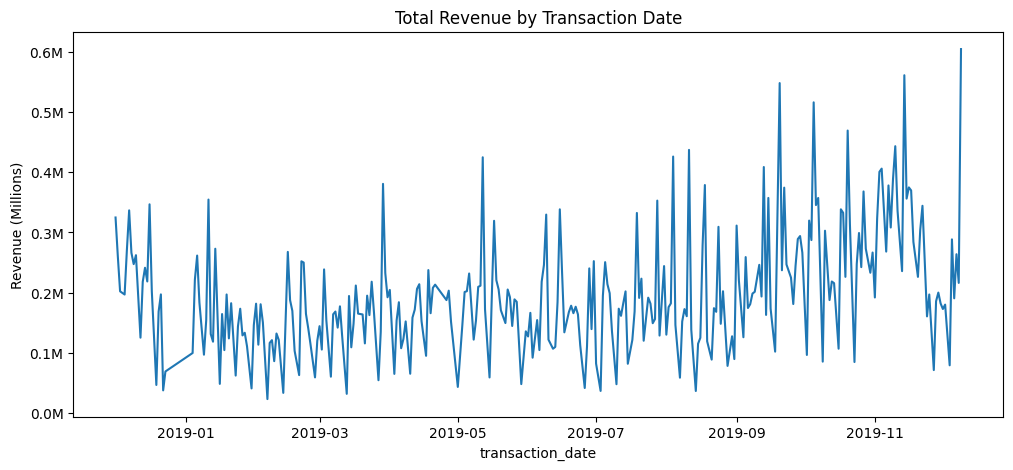

In [13]:
#Plot the sum of revenue on transaction_date in a line plot
df_group=df.groupby(['transaction_date'],as_index=False)['Revenue'].sum()
# plot the line plot
fig,ax=plt.subplots(figsize=(12,5))
ax=sns.lineplot(data=df_group, x='transaction_date',y='Revenue')
ax.set_title("Total Revenue by Transaction Date")
ax.set_ylabel("Revenue (Millions)")  # Set y-axis label
ax.yaxis.set_major_formatter(lambda x, pos: f'{x / 1000000:.1f}M')
plt.show()

**Summary**
- Data shows increasing trend
- Daily shows high variations, needs more investigation to check if this variation is due to weekends, holidays etc



**Question 1.3**

**Answer 1.3.1**

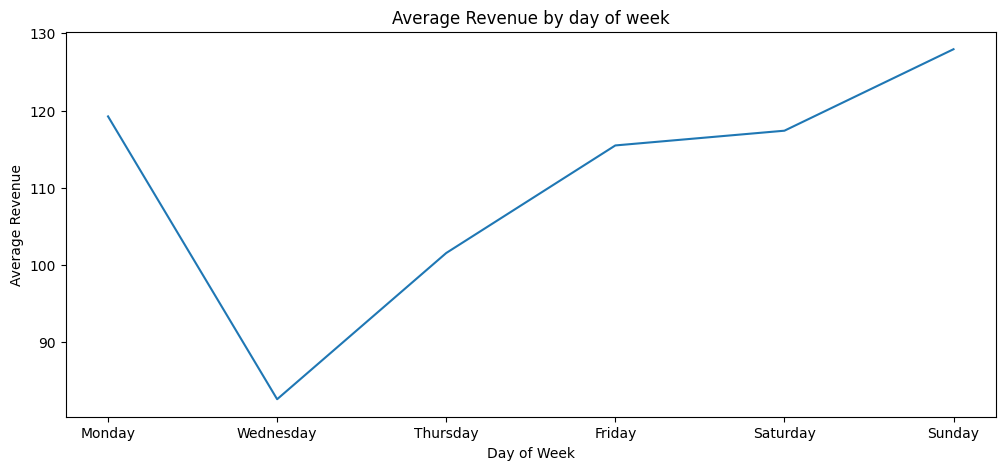

In [33]:
#create variable day of week
df['day_of_week']=df['transaction_date'].dt.dayofweek
#average revenue by day of week
df_avg_revenue=df.groupby(['day_of_week'],as_index=False)['Revenue'].mean()
#naming day of week 0-Monday to 6- Sunday
day_names = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
# mapping weekday name
df_avg_revenue["day_of_week_name"] = df_avg_revenue['day_of_week'].map(lambda x: day_names[x])

# #Plot the sum of revenue on transaction_date in a line plot
# plot the line plot
fig,ax=plt.subplots(figsize=(12,5))
ax=sns.lineplot(data=df_avg_revenue, x='day_of_week_name',y='Revenue',sort=True)
ax.set_title("Average Revenue by day of week")
ax.set_ylabel("Average Revenue")  # Set y-axis label
ax.set_xlabel("Day of Week")
plt.show()

**Answer 1.3.2**

In [34]:
df.columns

Index(['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category',
       'Price', 'Quantity', 'CustomerNo', 'Country', 'productName_process',
       'Revenue', 'transaction_date', 'day_of_week', 'day_name'],
      dtype='object')

In [40]:
df_prod_rev=df.groupby(['day_of_week','productName_process'],as_index=False)['Revenue'].sum()
df_prod_rev.sort_values(['day_of_week','Revenue'], ascending=False)

,day_of_week,productName_process,Revenue
19888,6,World War Gliders Asstd Designs,187081.343750
16804,6,Assorted Colour Bird Ornament,132705.609375
18805,6,Popcorn Holder,117119.632812
17361,6,Cream Hanging Heart T-Light Holder,108240.867188
18348,6,Mini Paint Set Vintage,100676.757812
...,...,...,...
2757,0,Small Glass Sundae Dish Clear,-84.480011
1934,0,Paper Lantern Point Star Moon,-87.000000
2077,0,Pink Metal Chicken Heart,-257.779999
1296,0,Hanging Bauble T-Light Holder Small,-315.219971


In [41]:
# prompt:  Identify the name of product (column productName_process) that contributes the highest revenue
# on ‘that workday’ (you need to find out from 1.3.1) and the name of product (column
# productName_process) that has the highest sales volume (sum of the Quantity), no need to remove
# negative quantity transactions.) on ‘that workday’ (you need to find out from 1.3.1).

# Find the workday with the highest average revenue from df_avg_revenue
highest_revenue_day = df_avg_revenue.loc[df_avg_revenue['Revenue'].idxmax()]['day_of_week']

# Filter the original DataFrame (df) for the workday with the highest average revenue
df_highest_revenue_day = df[df['day_of_week'] == highest_revenue_day]

# Group by product name and sum revenue to find the product with the highest revenue on that day
highest_revenue_product = df_highest_revenue_day.groupby('productName_process')['Revenue'].sum().idxmax()

# Group by product name and sum quantity to find the product with the highest sales volume on that day
highest_sales_volume_product = df_highest_revenue_day.groupby('productName_process')['Quantity'].sum().idxmax()

print(f"The product with the highest revenue on the workday with the highest average revenue ({highest_revenue_day}) is: {highest_revenue_product}")
print(f"The product with the highest sales volume on the workday with the highest average revenue ({highest_revenue_day}) is: {highest_sales_volume_product}")


The product with the highest revenue on the workday with the highest average revenue (6) is: World War  Gliders Asstd Designs
The product with the highest sales volume on the workday with the highest average revenue (6) is: World War  Gliders Asstd Designs
